In [1]:
import pandas as pd
import numpy as np

from model import NeuralNetwork, NeuralNetwork_Adjustable
from utils import count_parameters, plot_metrics

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchmetrics.classification import BinaryAccuracy, AUROC

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#from sklearn.decomposition import PCA
#from sklearn import metrics

import matplotlib.pyplot as plt
from IPython.display import clear_output

from time import time

import gc

In [2]:
sample_size  = int(1e+6)
df  = pd.read_hdf(f'/Users/asugu/Desktop/b_tag_DNN/data/all_data_{sample_size}.hdf5', key='data') 
#print(df)
df = df.astype(np.float32)  
#df = df.loc[df['jet_flavor'] == 5.0, :]   # Bottoms
df_charm = df.loc[df['jet_flavor'] == 4.0, :] 
df_light = df.loc[df['jet_flavor'] == 1.0, :] 

df = pd.concat([df_charm,df_light], axis=0)
print(df)


          jet_pt   jet_eta  jet_flavor  hl_trck_var_trck_2_d0_sig   
0      25.885900 -1.202390         4.0                   0.874096  \
1      29.147499 -1.195630         4.0                   0.634279   
2      25.676399  1.203180         4.0                   0.817854   
3      23.573601  1.678740         4.0                   3.722150   
4      23.941700 -0.398695         4.0                   2.123460   
...          ...       ...         ...                        ...   
99995  26.228500 -0.663639         4.0                   0.935804   
99996  24.043301 -1.391860         4.0                   3.276130   
99997  35.396500 -0.421217         4.0                   0.899555   
99998  26.479300  1.636440         4.0                   0.416047   
99999  24.644400  1.417870         4.0                   5.601360   

       hl_trck_var_trck_3_d0_sig  hl_trck_var_trck_2_z0_sig   
0                       0.198877                   0.327153  \
1                       0.508459             

In [3]:
df['pt_cosh']=df['jet_pt']*np.cosh(df['jet_eta'])
col_names = df.keys()
target_col_name = "jet_flavor"
input_col_names = [col_name for col_name in col_names if col_name != target_col_name]

df.replace({"inf": 0, "-inf": 0}, inplace=True)
df = df[(np.abs(df-df.mean()) <= 10*df.std()).all(axis=1)]

inputs = df[input_col_names]

del df
gc.collect()

47

In [4]:
train_inputs, val_inputs = train_test_split(inputs, test_size = 0.2, shuffle = True, random_state = 42)  # stratify ?

del inputs
gc.collect()

scaler = StandardScaler()
train_inputs = scaler.fit_transform(train_inputs)
val_inputs  = scaler.transform(val_inputs)

train_inputs = torch.tensor(train_inputs, dtype=torch.float32)
val_inputs = torch.tensor(val_inputs, dtype=torch.float32)

In [6]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, code):
        super(Autoencoder, self).__init__()
        mult=int((input_size/code)**(0.33334))       # change the cube root if you want to change number of layers
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_size, code*mult*mult),
            torch.nn.ReLU(),
            #torch.nn.Linear(code*mult*mult*mult, code*mult*mult),
            #torch.nn.ReLU(),
            torch.nn.Linear(code*mult*mult, code*mult),
            torch.nn.ReLU(),
            torch.nn.Linear(code*mult, code),
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(code, code*mult),
            torch.nn.ReLU(),
            torch.nn.Linear(code*mult, code*mult*mult),
            torch.nn.ReLU(),
           # torch.nn.Linear(code*mult*mult, code*mult*mult*mult),
            #torch.nn.ReLU(),
            torch.nn.Linear(code*mult*mult, input_size),
            torch.nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        #x = self.decoder(x)   # call decoder in train loop to get encoder only
        return x

In [9]:
batchsize = int(len(train_inputs)/100)
print(batchsize)
trainloader = DataLoader(train_inputs, batch_size = batchsize , drop_last=True )

744


In [12]:
num_epochs = 50
learning_rate = 0.003         #0.003
input_size  = len(input_col_names)
latent_size = 32

autoencoder = Autoencoder(input_size=input_size, code=latent_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)


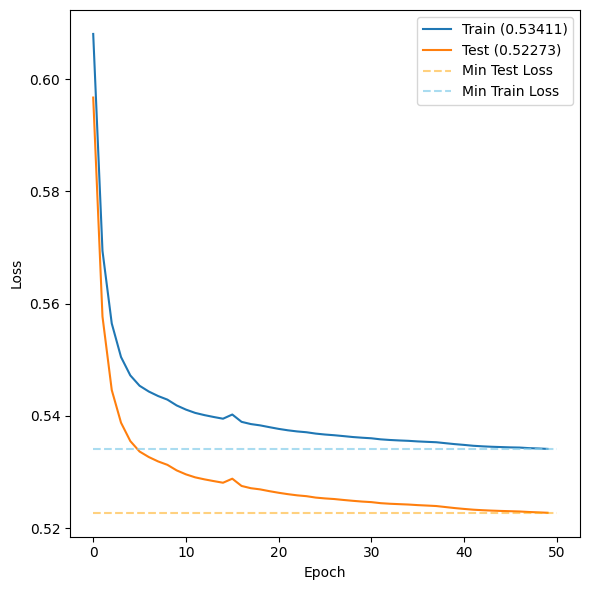

Training complete


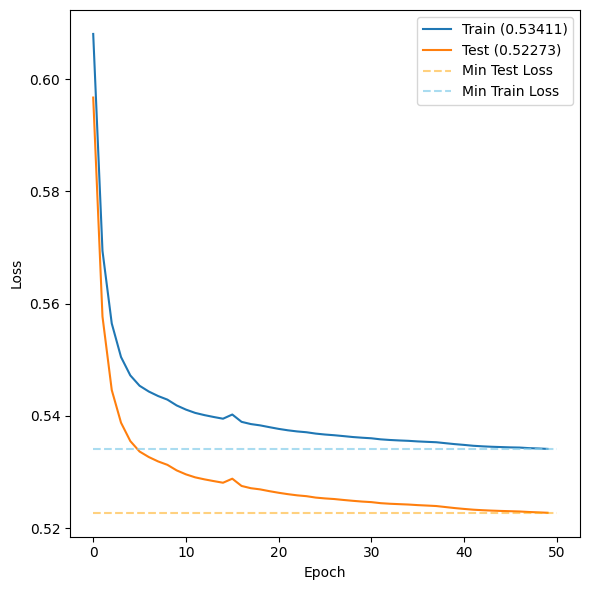

In [13]:
train_losses = []
val_losses = []
fig, axs = plt.subplots(1, figsize=(6, 6))
for i_epoch in range(num_epochs):
    autoencoder.train() 
    for i_batch,train_input in enumerate(trainloader):
        train_input = train_input.float()
        optimizer.zero_grad()
        
        encoded = autoencoder(train_input)
        train_pred = autoencoder.decoder(encoded)
        loss = criterion(train_pred, train_input)
        
        if not torch.isnan(loss): 
            loss.backward()
            optimizer.step()

    autoencoder.eval()
    with torch.no_grad():
        encoded = autoencoder(train_inputs)
        train_preds = autoencoder.decoder(encoded)
        
        val_encoded = autoencoder(val_inputs)
        val_preds = autoencoder.decoder(val_encoded)
   
        train_loss = criterion(train_preds, train_inputs)
        val_loss = criterion(val_preds, val_inputs)
        
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())
        
    scheduler.step()

    axs.clear()
    axs.plot(train_losses, label='Train ({:.5f})'.format(train_losses[-1]))
    axs.plot(val_losses, label='Test ({:.5f})'.format(val_losses[-1]))
    axs.plot([0, len(train_losses)], [min(val_losses), min(val_losses)], '--', color='orange' ,alpha=0.5, label='Min Test Loss')
    axs.plot([0, len(train_losses)], [min(train_losses), min(train_losses)], '--', color = 'skyblue',alpha=0.7, label='Min Train Loss')
    axs.set_xlabel('Epoch')
    axs.set_ylabel('Loss')
    axs.legend()
    
    fig.tight_layout()
    clear_output(wait=True)
    display(fig)

print('Training complete')


In [14]:
del train_inputs, val_inputs, trainloader, val_losses, train_losses
gc.collect()

907

In [15]:

#torch.save(autoencoder.state_dict(), 'C:\Users\Asu\Desktop\AutoEncoder\model.pth')

In [16]:

################################################################ device settings ################################################################
dtype  = 'np.float32'
device = device = "cpu" if torch.backends.mps.is_available() else "cpu"   #torch.device("cuda") if torch.cuda.is_available() else torch.device("mps")
print(f'Selected device: {device}')
################################################################ Data Preparation ################################################################
sample_size  = int(1e+6)
print('Preparing data...')
start = time()
       
df  = pd.read_hdf(f'/Users/asugu/Desktop/b_tag_DNN/data/all_data_{sample_size}.hdf5', key='data', dtype=dtype)   
df = df.astype(np.float32)  
df['pt_cosh']=df['jet_pt']*np.cosh(df['jet_eta']) 

Selected device: cpu
Preparing data...


In [17]:
col_names = df.keys()
target_col_name = "jet_flavor"
input_col_names = [col_name for col_name in col_names if col_name != target_col_name]
df.replace({"inf": 0, "-inf": 0}, inplace=True)

df = df[(np.abs(df-df.mean()) <= 10*df.std()).all(axis=1)]

inputs = df[input_col_names]
labels = df[target_col_name] 
labels = (labels==5).astype(int) #np.array([1 if i == 5 else 0 for i in labels]) 
## delete df and collect the garbage
del df
gc.collect()

0

In [18]:
train_inputs, val_inputs, train_labels, val_labels = train_test_split(inputs, labels, stratify = labels, test_size = 0.2, shuffle = True, random_state = 42)

del inputs, labels
gc.collect()

scaler = StandardScaler()
train_inputs = scaler.fit_transform(train_inputs)
val_inputs  = scaler.transform(val_inputs)                 # why they are different ?

train_inputs = torch.tensor(train_inputs,  dtype=torch.float32, device = device)
train_labels = torch.tensor(train_labels.to_numpy(),  dtype=torch.float32, device = device).reshape(-1, 1)

val_inputs  = torch.tensor(val_inputs,  dtype=torch.float32, device = device)
val_labels  = torch.tensor(val_labels.to_numpy(),  dtype=torch.float32, device = device).reshape(-1, 1)

batchsize   = int(len(train_inputs)/10)
trainloader = DataLoader(list(zip(train_inputs, train_labels)), batch_size = batchsize , drop_last=True )

finish = time()

In [32]:
class CustomLoss(nn.Module):
    def forward(self, inputs, targets):
        l1_loss = torch.abs(inputs - targets).mean()
        l2_loss = torch.sqrt(torch.pow(inputs - targets, 2).mean())
        loss = torch.max(l1_loss, l2_loss)
        return loss

In [33]:
print('Building model...', end='\r')
input_size  = latent_size
output_size = 1
#model = NeuralNetwork(input_size, output_size, nnode=32)
model = NeuralNetwork_Adjustable(input_size, output_size, n_hidden_layers = 2, nnodes=64)
count_parameters(model)

##################################################### Loss and Optimizer Settings #####################################################

def learning_rate(i_epoch, initial_lr = 0.01, decay_rate = 0.08):
    return initial_lr * (1-decay_rate)**i_epoch

criterion = CustomLoss()        #
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)  

n_epochs  = 50

+------------------------+------------+
|        Modules         | Parameters |
+------------------------+------------+
| hidden_layers.0.weight |    4096    |
|  hidden_layers.0.bias  |     64     |
| hidden_layers.1.weight |    4096    |
|  hidden_layers.1.bias  |     64     |
|     layer1.weight      |    2048    |
|      layer1.bias       |     64     |
|    layerfin.weight     |     64     |
|     layerfin.bias      |     1      |
+------------------------+------------+
Total Trainable Params: 10497


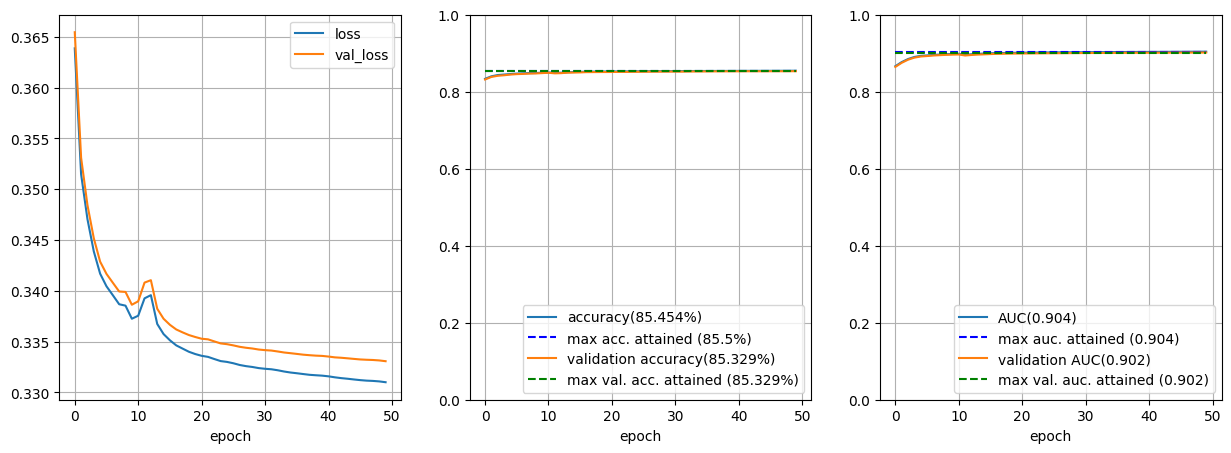

Training: Epoch [50/50] --- Loss: 0.3310 --- Accuracy: 0.8545 --- AUC: 0.904
Test    : Epoch [50/50] --- Loss: 0.3331 --- Accuracy: 0.8533 --- AUC: 0.902


In [34]:
train_losses = []
train_accuracies = []
train_aucs = []
val_losses = []
val_accuracies = []
val_aucs = []

for i_epoch in range(n_epochs):
    
    optimizer.param_groups[0]['lr'] = learning_rate(i_epoch, initial_lr=0.003, decay_rate=0.005) # change lr from here
    lr = optimizer.param_groups[0]['lr']
    print(f'learning rate was set to {lr:.5f}.')
    
    train_loop = trainloader      # ??????
    
    ############################################################ Batch Training ############################################################
    model.to(device)   
    model.train() 
    autoencoder.to(device)
    autoencoder.eval()
    
    for i_batch, (train_input, train_label) in enumerate(train_loop):
        
        train_input = train_input.float().to(device)
        train_label = train_label.reshape(-1,1).float().to(device)
        
        with torch.no_grad():
            encoded = autoencoder(train_input)
        train_pred = model(encoded)
        
        loss = criterion(train_pred, train_label)

        optimizer.zero_grad()
        if not torch.isnan(loss): 
            loss.backward()
            optimizer.step()
        
    #########################################################  Evaluate metrics #########################################################
    
    print('Evaluating metrics...', end='\r')
    
    acc_metric = BinaryAccuracy()
    auc_metric = AUROC(task="binary")
    
    model.eval()
        
    with torch.no_grad():
        
        model.to('cpu')
        val_inputs = val_inputs.cpu()
        val_labels = val_labels.cpu()
        
        encoded = autoencoder(train_inputs)
        train_preds = model(encoded)
        
        val_encoded = autoencoder(val_inputs)
        val_preds  = model(val_encoded)
        
        train_loss = criterion(train_preds, train_labels)
        val_loss  = criterion(val_preds, val_labels)
        
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())
        
        train_accuracy = acc_metric(train_preds, train_labels)
        val_accuracy = acc_metric(val_preds, val_labels)
        
        train_accuracies.append(train_accuracy.item())
        val_accuracies.append(val_accuracy.item())
        
        train_auc = auc_metric(train_preds, train_labels)
        val_auc = auc_metric(val_preds, val_labels)
        
        train_aucs.append(train_auc.item())
        val_aucs.append(val_auc.item())
    
    plot_metrics(np.arange(i_epoch+1), train_losses, val_losses, train_accuracies, val_accuracies, train_aucs, val_aucs)
        
     
    print('Evaluating metrics finished!', end='\r')  
    print(f'Training: Epoch [{i_epoch+1}/{n_epochs}] --- Loss: {train_losses[-1]:.4f} --- Accuracy: {train_accuracies[-1]:.4f} --- AUC: {train_aucs[-1]:.3f}\nTest    : Epoch [{i_epoch+1}/{n_epochs}] --- Loss: {val_losses[-1]:.4f} --- Accuracy: {val_accuracies[-1]:.4f} --- AUC: {val_aucs[-1]:.3f}\n', end='\r')


# put all metrics to dictionary and save it for further analysis
keys         = ['train_losses','train_accuracies','train_aucs','val_losses','val_accuracies', 'val_aucs']
values       = [train_losses , train_accuracies , train_aucs , val_losses , val_accuracies , val_aucs]
dict_metrics = {keys[i]: values[i] for i in range(len(keys))}

#with open('history_dict.pickle', 'wb') as file:
 #   pickle.dump(dict_metrics, file)